# Lesson 1

In [1]:
%load_ext autoreload
%autoreload 2
# load libraries and edit the modules so you can use them


%matplotlib inline
# allows inline plotting

In [2]:
#pip install scikit-learn

In [4]:
import os
import sys
from fastai.imports import *
from fastai.tabular import *

#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics


## Some Essential Functions...

In [5]:
"""
Some Essential Functions...

"""
#from .imports import *


#from sklearn.pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute._base import SimpleImputer as Imputer
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
#from sklearn.ensemble import forest

from sklearn.ensemble import RandomForestRegressor
def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string or list of strings that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    >>>df2 = pd.DataFrame({'start_date' : pd.to_datetime(['3/11/2000','3/13/2000','3/15/2000']),
                            'end_date':pd.to_datetime(['3/17/2000','3/18/2000','4/1/2000'],infer_datetime_format=True)})
    >>>df2
        start_date	end_date    
    0	2000-03-11	2000-03-17
    1	2000-03-13	2000-03-18
    2	2000-03-15	2000-04-01
    >>>add_datepart(df2,['start_date','end_date'])
    >>>df2
    	start_Year	start_Month	start_Week	start_Day	start_Dayofweek	start_Dayofyear	start_Is_month_end	start_Is_month_start	start_Is_quarter_end	start_Is_quarter_start	start_Is_year_end	start_Is_year_start	start_Elapsed	end_Year	end_Month	end_Week	end_Day	end_Dayofweek	end_Dayofyear	end_Is_month_end	end_Is_month_start	end_Is_quarter_end	end_Is_quarter_start	end_Is_year_end	end_Is_year_start	end_Elapsed
    0	2000	    3	        10	        11	        5	            71	            False	            False	                False	                False	                False	            False	            952732800	    2000	    3	        11	        17	    4	            77	            False	            False	            False	            False	                False	        False	            953251200
    1	2000	    3	        11	        13	        0	            73	            False	            False	                False	                False               	False           	False           	952905600     	2000       	3	        11      	18  	5           	78          	False	            False           	False           	False               	False          	False           	953337600
    2	2000	    3	        11	        15	        2           	75          	False           	False               	False               	False               	False               False           	953078400      	2000    	4          	13      	1   	5           	92          	False           	True            	False           	True                	False          	False           	954547200
    """
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr:
            if n == 'Week':
                df[targ_pre + n] = fld.dt.isocalendar().week
            else:
                df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    from pandas.api.types import is_string_dtype
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for col in df.select_dtypes(include=['object'] or ['string']).columns:
        df[col] = df[col].astype('category')
    
    
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]):
            try:
                # Attempt conversion and handle potential errors
                df[col] = df[col].astype('category')
                df[col] = df[col].cat.as_ordered()  # Set as ordered category
            except TypeError as e:
                print(f"Warning: Unable to convert column '{col}' to categorical: {e}")
            except ValueError as e:
                print(f"Warning: Potential issues with column '{col}': {e}")

    return df

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=scikit-learn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

"""def set_rf_samples(n):
     Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
"""

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    RandomForestRegressor._generate_sample_indices = (lambda rs, n_samples:
        RandomForestRegressor.check_random_state(rs).randint(0, n_samples, n))

# Example usage:
set_rf_samples(100)  # Set the number of samples you want for each tree
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    RandomForestRegressor._generate_sample_indices = (lambda rs, n_samples:
        RandomForestRegressor.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]
    


In [9]:
PATH = "C:/Users/user/bluebook-for-bulldozers/"
os.listdir(PATH)


['Data Dictionary.xlsx',
 'desktop.ini',
 'Machine_Appendix.csv',
 'median_benchmark.csv',
 'random_forest_benchmark_test.csv',
 'Test.csv',
 'Train.7z',
 'Train.csv',
 'Train.zip',
 'TrainAndValid.7z',
 'TrainAndValid.csv',
 'TrainAndValid.zip',
 'Valid.7z',
 'Valid.csv',
 'Valid.zip',
 'ValidSolution.csv']

In [10]:
df_raw = pd.read_csv(f'{PATH}Train.csv',low_memory = False,parse_dates = ['saledate'])


In [11]:
def display_all(df):
    with pd.option_context("display.max_rows",1000,"display.max_columns",1000):
        display(df)
    

In [12]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1.0,1.0,1.0,2.0,2.0
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [13]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
SalesID,401125.0,NaN,NaN,NaN,1919712.521503,1139246.0,1418371.0,1639422.0,2242707.0,6333342.0,909021.492667
SalePrice,401125.0,NaN,NaN,NaN,31099.712848,4750.0,14500.0,24000.0,40000.0,142000.0,23036.898502
MachineID,401125.0,NaN,NaN,NaN,1217902.517971,0.0,1088697.0,1279490.0,1468067.0,2486330.0,440991.954249
ModelID,401125.0,NaN,NaN,NaN,6889.70298,28.0,3259.0,4604.0,8724.0,37198.0,6221.777842
datasource,401125.0,NaN,NaN,NaN,134.66581,121.0,132.0,132.0,136.0,172.0,8.962237
auctioneerID,380989.0,NaN,NaN,NaN,6.55604,0.0,1.0,2.0,4.0,99.0,16.976779
YearMade,401125.0,NaN,NaN,NaN,1899.156901,1000.0,1985.0,1995.0,2000.0,2013.0,291.797469
MachineHoursCurrentMeter,142765.0,NaN,NaN,NaN,3457.955353,0.0,0.0,0.0,3025.0,2483300.0,27590.256413
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,NaN,NaN,NaN,2004-08-02 07:47:13.986413184,1989-01-17 00:00:00,2000-10-07 00:00:00,2006-03-23 00:00:00,2009-03-24 00:00:00,2011-12-30 00:00:00,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [14]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Initial Processing

In [15]:
m =  RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop("SalePrice",axis=1),df_raw.SalePrice)

ValueError: could not convert string to float: 'Low'

This dataset contains a mix of continuous and categorical variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [16]:
add_datepart(df_raw,'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int32

In [17]:
df_raw["UsageBand"].dtype.name

'object'

In [18]:
train_cats(df_raw)

In [19]:
df_raw.UsageBand.dtype

CategoricalDtype(categories=['High', 'Low', 'Medium'], ordered=False, categories_dtype=object)

In [20]:
df_raw.fiBaseModel.dtype

CategoricalDtype(categories=['10', '100', '104', '1066', '1080', '1088', '10DG', '11',
                  '110', '1105',
                  ...
                  'ZX370', 'ZX450', 'ZX460', 'ZX50', 'ZX600', 'ZX70', 'ZX75',
                  'ZX80', 'ZX800', 'ZX850'],
, ordered=False, categories_dtype=object)

We can specify the order to use for categorical variables if we wish:

In [21]:
df_raw.UsageBand.cat.set_categories(['High', 'Low', 'Medium'],ordered =True)

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
401120       NaN
401121       NaN
401122       NaN
401123       NaN
401124       NaN
Name: UsageBand, Length: 401125, dtype: category
Categories (3, object): ['High' < 'Low' < 'Medium']

In [22]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [23]:
df_raw.UsageBand

0         1
1         1
2         0
3         0
4         2
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Name: UsageBand, Length: 401125, dtype: int8

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [24]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [ ]:
"""os.makedirs('tmp',exist_ok=True)
df_raw.to_feather('C:/Users/ASUS/bluebook-for-bulldozers/')"""

## Pre-processing

In thee future we can simply read it from this format

In [ ]:
"""df_raw = pd.read_feather("path/")"""

In [25]:
df , y , nas = proc_df(df_raw,"SalePrice")

We now have something we can pass to a Random Forest

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly the most important idea in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it. And suppose you have lots of parameters:

[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice. Why is that? If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to overfitting. A validation set helps diagnose this problem.

In [26]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid =12000 # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train,raw_valid = split_vals(df_raw,n_trn)
x_train,x_valid = split_vals(df,n_trn)
y_train,y_valid = split_vals(y,n_trn)

x_train.shape, y_train.shape, x_valid.shape

((389125, 66), (389125,), (12000, 66))

## Random Forests

## Base Model

Let's try our model again, this time with separate training and validation sets.

In [27]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(x_train), y_train), rmse(m.predict(x_valid), y_valid),
                m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)


In [28]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: total: 16min 8s
Wall time: 4min 24s
[0.07570646473809536, 0.23469122065166842, 0.9880215462891998, 0.9016347587257298]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [29]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
x_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [30]:
 m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: total: 34 s
Wall time: 9.61 s
[0.09242998254096021, 0.3516364842478187, 0.9814622536518319, 0.779181308318978]


## Single Tree

In [31]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.5246822241203416, 0.5822747806401765, 0.4026568399765402, 0.3945142383941427]


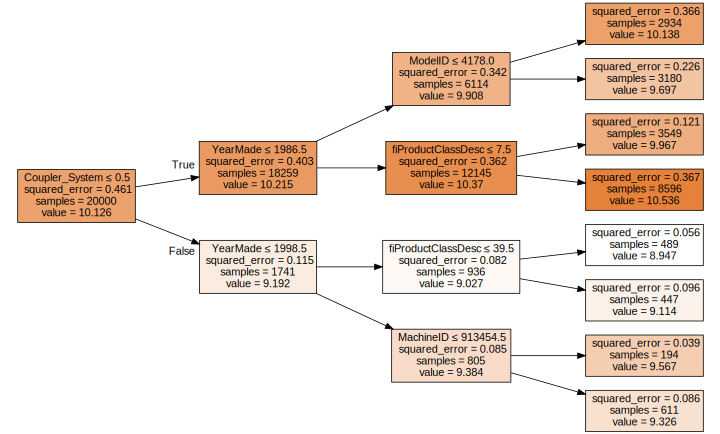

In [32]:
import graphviz
from sklearn.tree import export_graphviz
import IPython

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
    
draw_tree(m.estimators_[0], df_trn, precision=3)

In [33]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[5.329070518200751e-17, 0.46388040437350964, 1.0, 0.6157091640363259]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use bagging of multiple trees to get more generalizable results.

## Bagging

## Intro to Bagging

To learn about bagging in random forests, let's start with our basic model again.

In [34]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=10)
m.fit(x_train, y_train)
print_score(m)

[0.1111476232550818, 0.35849773378831595, 0.9731940283433814, 0.7704798583298511]


We'll grab the predictions for each individual tree, and look at one example.

In [35]:
preds = np.stack([t.predict(x_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted w

(array([9.58190393, 9.21034037, 9.04782144, 9.15904708, 9.10497986,
        9.10497986, 9.21034037, 9.25913054, 9.10497986, 9.10497986]),
 9.188850315384709,
 9.104979856318357)

In [36]:
preds.shape

(10, 12000)

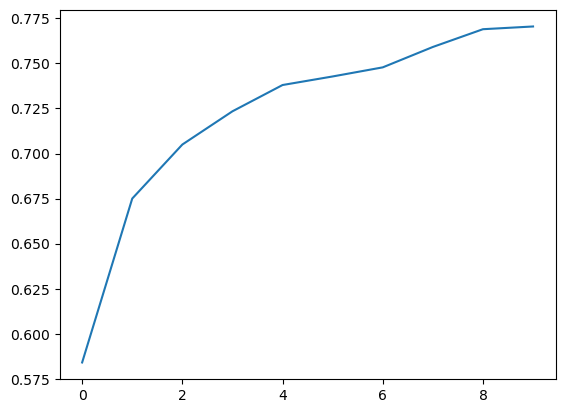

In [37]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [38]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.10119025989077347, 0.3552186931574695, 0.9777818130839167, 0.7746593211357743]


In [39]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.09612209913579271, 0.3477057080489786, 0.9799516938188813, 0.7840905681932263]


In [40]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.09308367041245283, 0.345041721163703, 0.9811991193306406, 0.787386323645835]


## Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our print_score function below.

In [41]:
m = RandomForestRegressor(n_estimators=40, oob_score = True, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.09570478977415393, 0.34347170510556013, 0.9801253934132533, 0.7893167999800904, 0.8580517926700412]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: subsampling. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [42]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
x_train, x_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.



In [43]:
set_rf_samples(20000)

In [44]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: total: 16min 54s
Wall time: 4min 48s
[0.07566723414861744, 0.23488039046067688, 0.9880339573837226, 0.9014761227689667, 0.912795934056348]


In [45]:
x_train.shape,y_train.shape

((389125, 66), (389125,))

Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [47]:
m = RandomForestRegressor(n_estimators=60, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.07712654295329484, 0.23649442350678138, 0.987567955474764, 0.9001174127735271, 0.9107466204692977]


## Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [48]:
reset_rf_samples()


Let's get a baseline for this full set to compare to.

In [49]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [50]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.07618282061617222, 0.23444937223176665, 0.9878703317698113, 0.9018373842915737, 0.9121896047693262]


In [51]:
t=m.estimators_[0].tree_


In [52]:
dectree_max_depth(t)

45

In [68]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.13975441744618844, 0.23273268451953216, 0.9591806660026375, 0.9032696560442537, 0.9091896138611075]


In [69]:
t=m.estimators_[0].tree_


In [70]:
dectree_max_depth(t)


38

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

    There are less decision rules for each leaf node; simpler models should generalize better
    The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [71]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.1137688648408794, 0.23268573007371934, 0.9729491026908055, 0.9033086833216714, 0.9111746662398328]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying max_features, which is the proportion of features to randomly select from at each split.

None,
0.,5
'sqr,t('
1, 3, 5, 10, 25, )100


In [72]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.1178579653623811, 0.227184835762369, 0.970969621055769, 0.9078263781226985, 0.9144716913643457]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs show an example of different max_features methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models: sklearn max_features chart

# Lessson 2

# Interpreting Machine Learning Modules

## Load in our data from the lesson 

In [97]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [98]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [99]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,1,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,1,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,2,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [100]:
%matplotlib inline

from fastai.imports import *
from fastai.tabular import *
#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [101]:
set_plot_sizes(12,14,16)

## Confidence Based on Tree Variance

In [102]:
set_rf_samples(50000)

In [104]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11773294288661057, 0.22601257990529566, 0.9710311786228986, 0.9087751412762916, 0.9146897940606415]


In [105]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]) , np.std(preds[:,0])

C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted w

CPU times: total: 312 ms
Wall time: 547 ms


C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted w

(9.185259098777335, 0.21465812745979798)

In [106]:
preds

array([[9.01938125, 9.12756876, 9.65003558, ..., 9.6989591 , 9.40211537,
        9.40211537],
       [9.19923692, 9.13886321, 9.19923692, ..., 9.25388121, 9.16985766,
        9.16985766],
       [9.0287734 , 9.12053202, 9.06124449, ..., 9.47504807, 9.25388121,
        9.25388121],
       ...,
       [9.34115241, 9.11411285, 9.13561749, ..., 9.68921809, 9.39073471,
        9.39073471],
       [9.02435879, 9.15273538, 9.0682003 , ..., 9.11392475, 9.17838203,
        9.17838203],
       [9.13911415, 8.94544849, 9.37234609, ..., 9.36143543, 9.35517747,
        9.35517747]])

In [107]:
preds.shape

(80, 12000)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [108]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted w

CPU times: total: 297 ms
Wall time: 535 ms


C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted w

(9.185259098777335, 0.21465812745979798)


We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

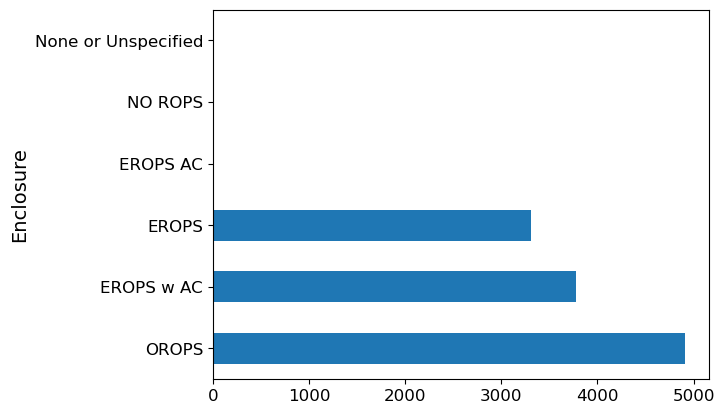

In [109]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [110]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

C:\Users\user\AppData\Local\Temp\ipykernel_14648\353751994.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()


,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839284,0.249640
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.592381,0.233427
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682870,0.203876


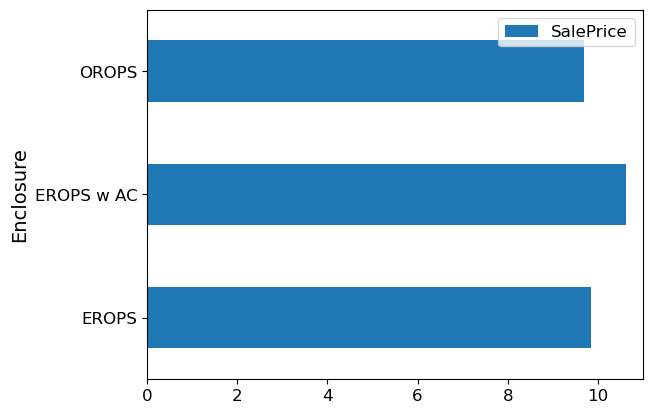

In [111]:

enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

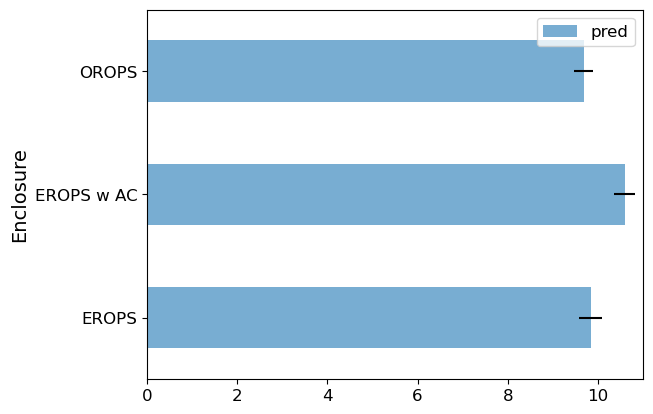

In [112]:

enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

Question: Why are the predictions nearly exactly right, but the error bars are quite wide?

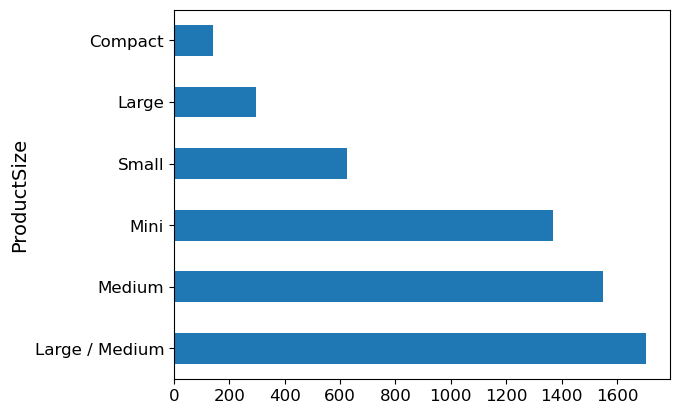

In [113]:
raw_valid.ProductSize.value_counts().plot.barh();

In [114]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

C:\Users\user\AppData\Local\Temp\ipykernel_14648\3711835709.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summ = x[flds].groupby(flds[0]).mean()


,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.826549,0.299234
Large,10.470589,10.416971,0.333086
Large / Medium,10.691871,10.659195,0.267536
Medium,10.681511,10.633007,0.245184
Mini,9.535147,9.556439,0.221968
Small,10.324448,10.335968,0.284405


### Calculating Coefficient of Variance

In [115]:
(summ.pred_std/summ.pred).sort_values(ascending=False) 

ProductSize
Large             0.031975
Compact           0.030452
Small             0.027516
Large / Medium    0.025099
Mini              0.023227
Medium            0.023059
dtype: float64

## Feature Importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [116]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.168400
37,Coupler_System,0.109011
13,ProductSize,0.088006
14,fiProductClassDesc,0.081431
2,ModelID,0.057695
63,saleElapsed,0.054307
10,fiSecondaryDesc,0.048222
39,Hydraulics_Flow,0.044913
19,Enclosure,0.038830
38,Grouser_Tracks,0.038257


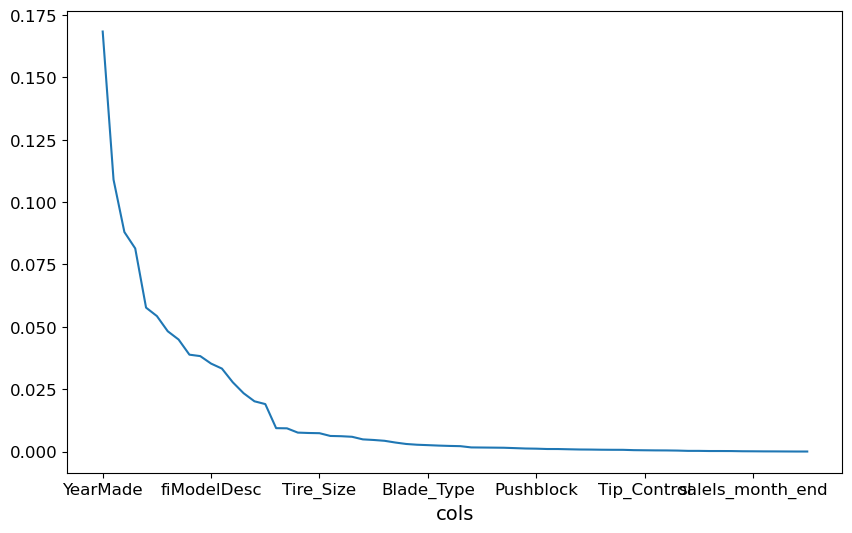

In [117]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [118]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

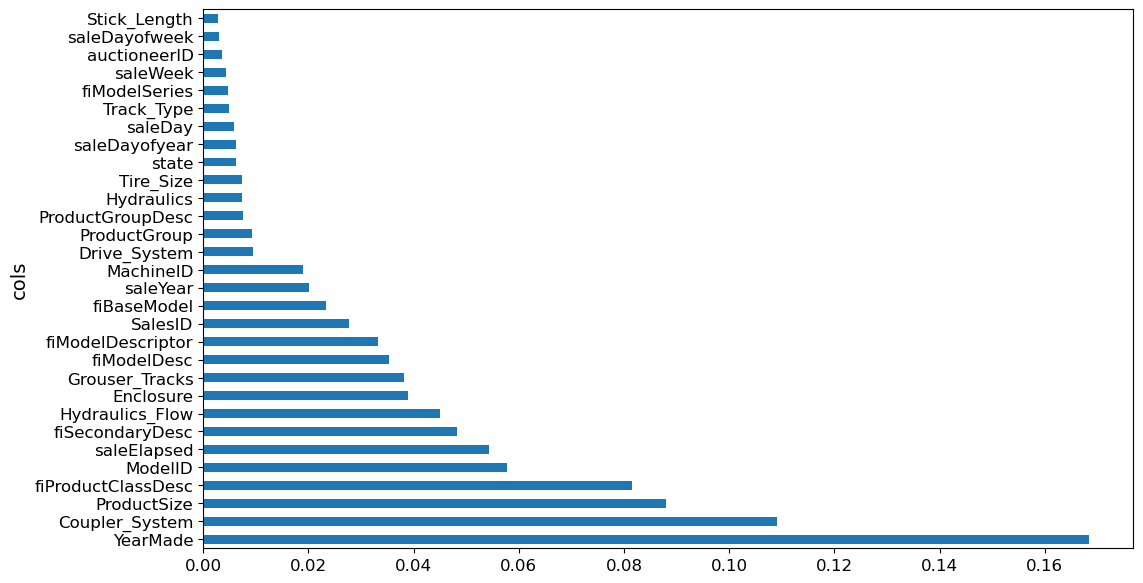

In [119]:
plot_fi(fi[:30])

In [120]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [121]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [123]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [124]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12272067427140122, 0.22380341888211164, 0.9685246700341851, 0.9105497811869602, 0.9127938146203548]


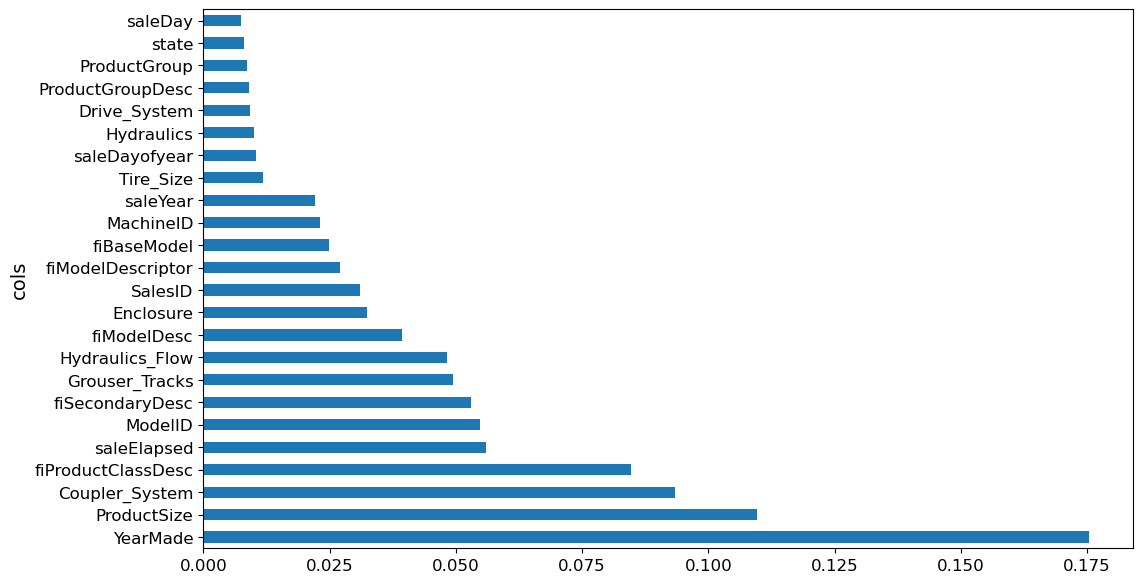

In [125]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot Encoding

proc_df's optional max_n_cat argument will turn some categorical variables into new columns.

and the column ProductSize gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the max_n_cat argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [139]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11665725737185438, 0.23264439215895363, 0.9715581167173691, 0.9033430357708738, 0.9132206985247844]


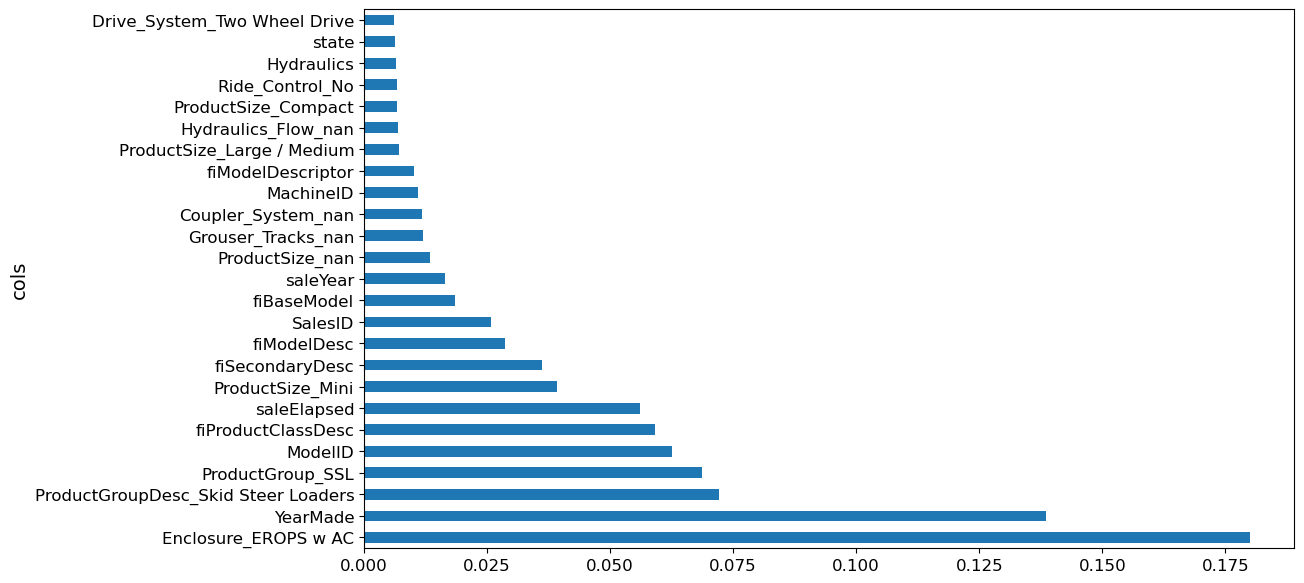

In [140]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## Removing rebundant Features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [141]:
from scipy.cluster import hierarchy as hc

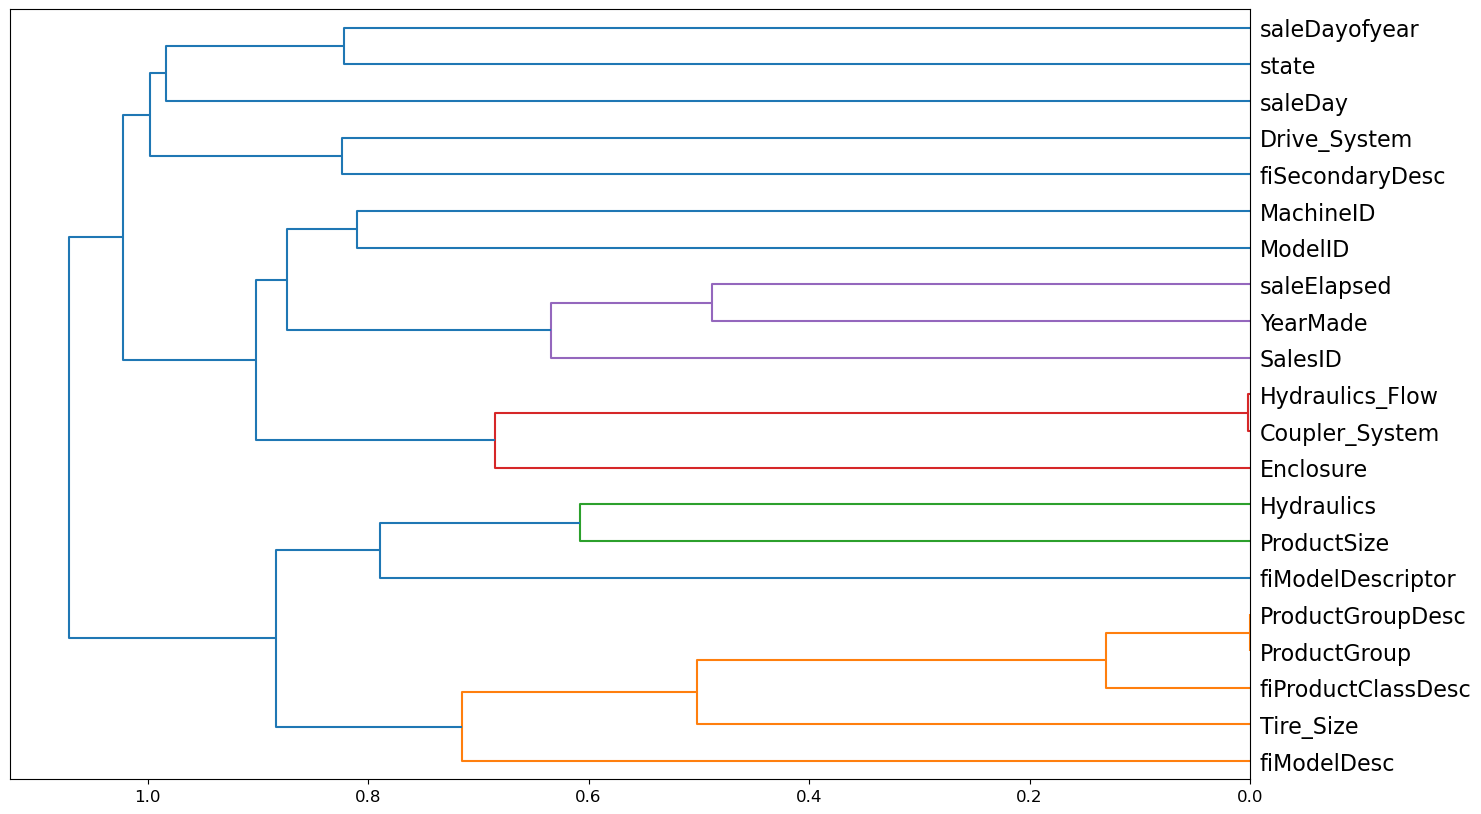

In [142]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [143]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=80, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

here's our Baseline

In [144]:
get_oob(df_keep)

0.9099190710288285

Now we try removing each variable at a time

In [132]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

C:\Users\user\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


saleYear 0.9057652418996287
saleElapsed 0.9042817730216361
fiModelDesc 0.9060926118469839
fiBaseModel 0.9059822147179993
Grouser_Tracks 0.9070005042818088
Coupler_System 0.9069842463212668


It looks like we can try one from each group for removal.Let's see what that does

In [145]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))
    

KeyError: "['saleYear', 'fiBaseModel', 'Grouser_Tracks'] not found in axis"

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [134]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [135]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [136]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

In [137]:
keep_cols

array(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Hydraulics_Flow',
       'Enclosure', 'fiModelDesc', 'fiModelDescriptor', 'SalesID',
       'MachineID', 'Drive_System', 'ProductGroup', 'ProductGroupDesc',
       'Hydraulics', 'Tire_Size', 'state', 'saleDayofyear', 'saleDay'],
      dtype=object)

And let's see how this model looks on the full dataset.

In [138]:
reset_rf_samples()

In [125]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12567491147748266, 0.2274470394947904, 0.9669910277881749, 0.9076134923073103, 0.9087894470439651]


## PArtial Dependance

In [128]:
from pdpbox import pdp
from plotnine import *

In [129]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [130]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

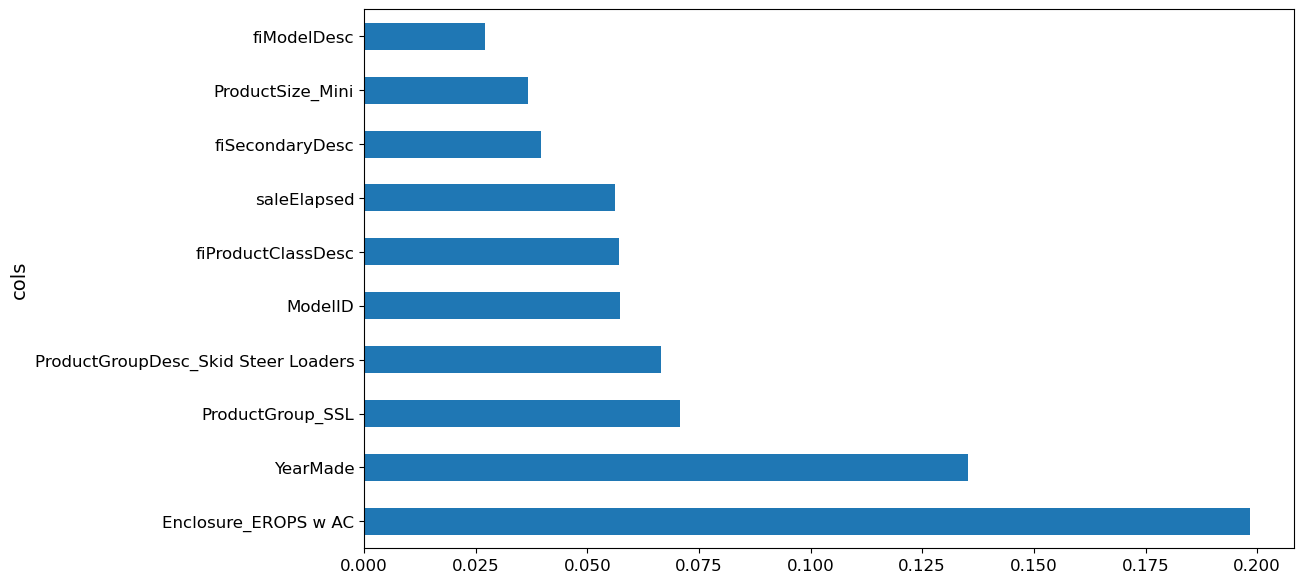

In [131]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

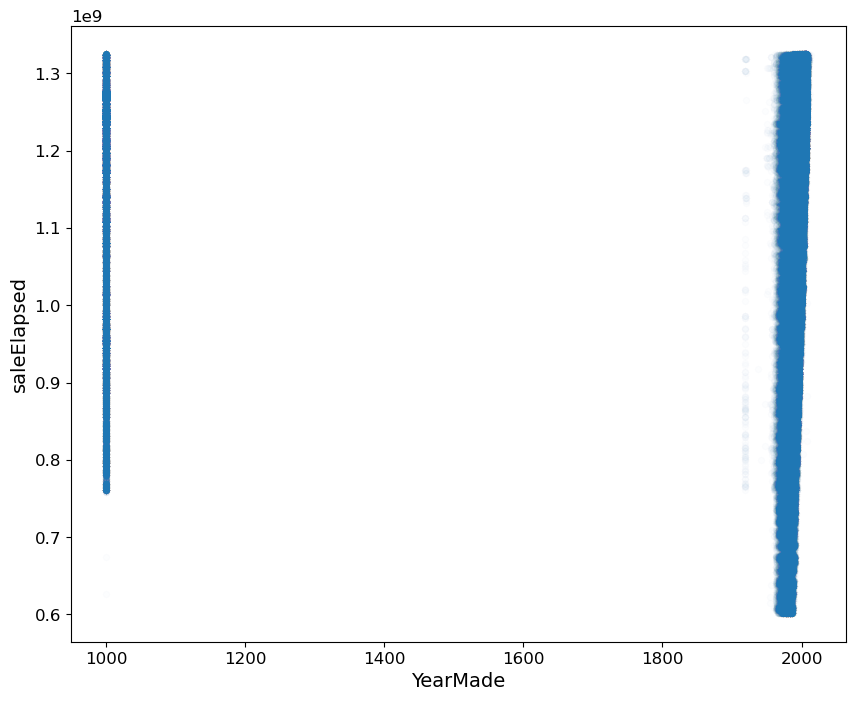

In [132]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [133]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

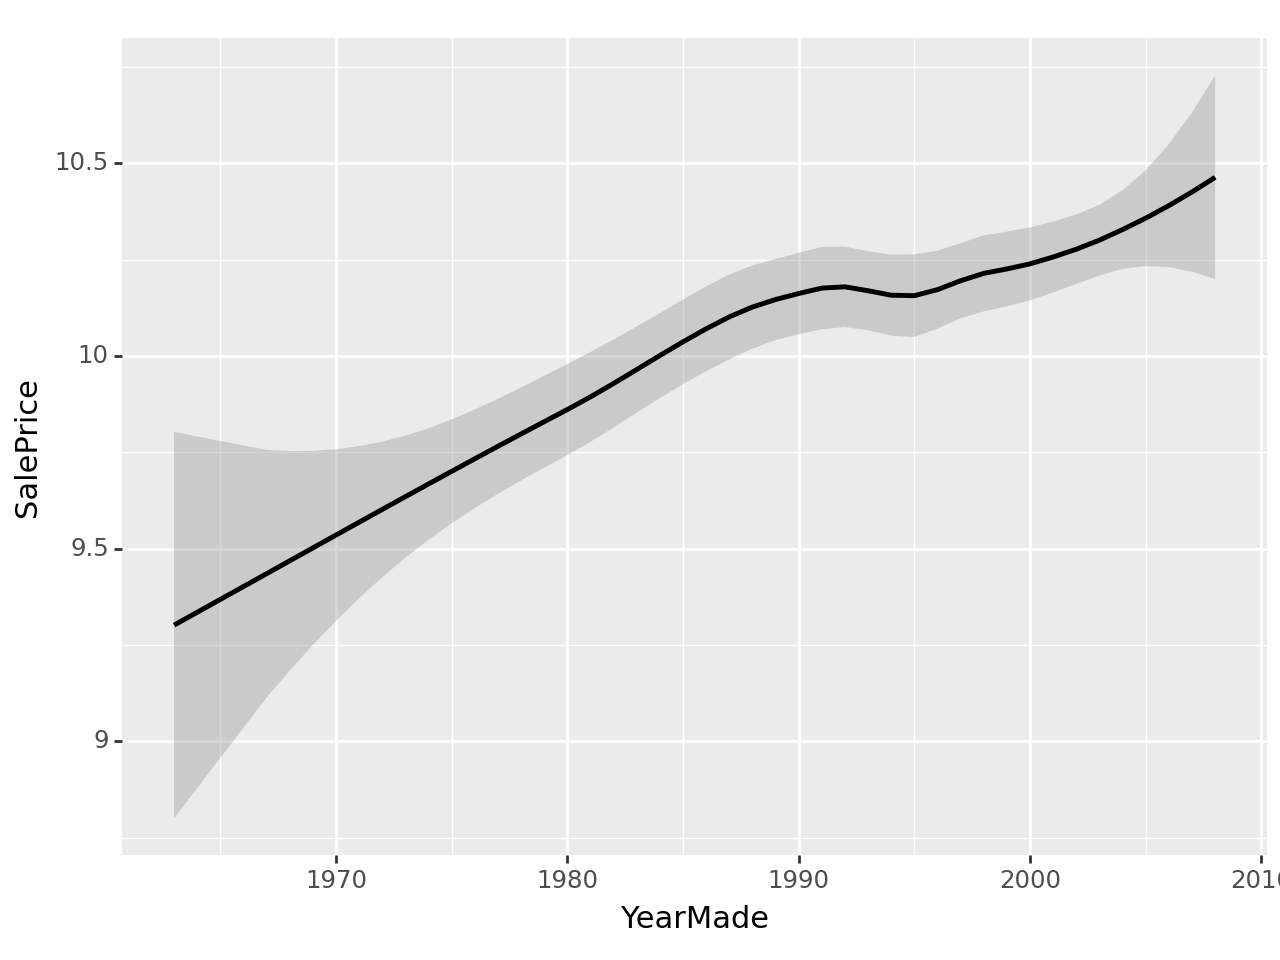

<Figure Size: (640 x 480)>

In [152]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [153]:
x = get_sample(X_train[X_train.YearMade>1930], 500)


In [159]:
def plot_pdp(model, dataset, feature, clusters=None, feature_name=None, is_categorical=False):
    """
    Plot Partial Dependence Plot (PDP) for a specific feature.

    Parameters:
    - model: The trained machine learning model.
    - dataset: The dataset used for plotting the PDP.
    - feature: The feature for which the PDP is generated.
    - clusters: Number of clusters for clustering lines in the PDP plot.
    - feature_name: The name of the feature (optional, default is the same as the input feature).
    - is_categorical: Boolean indicating whether the feature is categorical (default is False).

    Returns:
    - None (displays the PDP plot).
    """
    feature_name = feature_name or feature
    
    if is_categorical:
        pdp_feature = pdp.pdp_isolate(model=model, dataset=dataset, model_features=dataset.columns, feature=feature)
        pdp.pdp_plot(pdp_feature, feature_name, plot_lines=True,
                     cluster=clusters is not None,
                     n_cluster_centers=clusters)
    else:
        pdp_feature = pdp.pdp_isolate(model=model, dataset=dataset, model_features=dataset.columns, feature=feature)
        pdp.pdp_plot(pdp_feature, feature_name)
        
    plt.show()


In [1]:
plot_pdp(m, x, 'YearMade', is_categorical=True)

NameError: name 'plot_pdp' is not defined